In [1]:
from datasets import load_dataset

dataset = load_dataset("cnn_dailymail", "3.0.0")
print(f"Features {dataset['train'].column_names}")



Features ['article', 'highlights', 'id']


In [2]:
sample = dataset['train'][1]
print(f"Article (excerpt of 500 characters, total length: {len(sample['article'])}):")
print(sample['article'][:500])
print(f'\nSummary (length: {len(sample['highlights'])}):')
print(sample['highlights'])

Article (excerpt of 500 characters, total length: 4051):
Editor's note: In our Behind the Scenes series, CNN correspondents share their experiences in covering news and analyze the stories behind the events. Here, Soledad O'Brien takes users inside a jail where many of the inmates are mentally ill. An inmate housed on the "forgotten floor," where many mentally ill inmates are housed in Miami before trial. MIAMI, Florida (CNN) -- The ninth floor of the Miami-Dade pretrial detention facility is dubbed the "forgotten floor." Here, inmates with the most s

Summary (length: 281):
Mentally ill inmates in Miami are housed on the "forgotten floor"
Judge Steven Leifman says most are there as a result of "avoidable felonies"
While CNN tours facility, patient shouts: "I am the son of the president"
Leifman says the system is unjust and he's fighting for change .


In [3]:
sample_text = dataset['train'][1]['article'][:2000]
summaries = {}

import nltk 
from nltk.tokenize import sent_tokenize

nltk.download('punkt')

string = 'The United States is a county. The United Nations is an organization.'
sent_tokenize(string)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\synth\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


['The United States is a county.', 'The United Nations is an organization.']

In [4]:
def three_sentence_summary(text): 
    return '\n'.join(sent_tokenize(text)[:3])

summaries['baseline'] = three_sentence_summary(sample_text)

In [5]:
# by adding 'TL;DR' to the end of an expression we can get GPT-2 to create summaries of information

from transformers import pipeline, set_seed

set_seed(42) 
pipe = pipeline('text-generation', model='gpt2-xl')
gpt2_query = sample_text + '\nTL;DR:\n'
pipe_out = pipe(gpt2_query, max_length=512, clean_up_tokenization_spaces=True)
summaries['gpt2'] = '\n'.join(sent_tokenize(pipe_out[0]['generated_text'][len(gpt2_query) :]))


c:\Users\synth\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [6]:
# T5 transformer 
pipe = pipeline('summarization', model='t5-large')
pipe_out = pipe(sample_text)
summaries['t5'] = '\n'.join(sent_tokenize(pipe_out[0]['summary_text']))

In [7]:
pipe = pipeline('summarization', model='facebook/bart-large-cnn')
pipe_out = pipe(sample_text)
summaries['bart'] = '\n'.join(sent_tokenize(pipe_out[0]['summary_text']))

In [8]:
pipe = pipeline('summarization', model='google/pegasus-cnn_dailymail')
pipe_out = pipe(sample_text)
summaries['pegasus'] = pipe_out[0]['summary_text'].replace('<n>', '\n')

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
pipe = pipeline('summarization', model='microsoft/prophetnet-large-uncased')
pipe_out = pipe(sample_text, max_length=150, min_length=40, do_sample=False)
summaries['prophetnet'] = '\n'.join(sent_tokenize(pipe_out[0]['summary_text']))

c:\Users\synth\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\configuration_utils.py:363: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


In [10]:
# Comparing Summaries 

print('GROUND TRUTH')
print(dataset['train'][1]['highlights'], '\n')

for model_name in summaries: 
    print(model_name.upper())
    print(summaries[model_name], '\n')

GROUND TRUTH
Mentally ill inmates in Miami are housed on the "forgotten floor"
Judge Steven Leifman says most are there as a result of "avoidable felonies"
While CNN tours facility, patient shouts: "I am the son of the president"
Leifman says the system is unjust and he's fighting for change . 

BASELINE
Editor's note: In our Behind the Scenes series, CNN correspondents share their experiences in covering news and analyze the stories behind the events.
Here, Soledad O'Brien takes users inside a jail where many of the inmates are mentally ill. An inmate housed on the "forgotten floor," where many mentally ill inmates are housed in Miami before trial.
MIAMI, Florida (CNN) -- The ninth floor of the Miami-Dade pretrial detention facility is dubbed the "forgotten floor." 

GPT2
To get to the jail, you go up a flight of stairs, pass a metal detector, and go down a hall.
The inmates are so scared that they'll be thrown in jail for not turning up your appointment.
The first room to the right i

In [11]:
from datasets import load_metric
import pandas as pd
import numpy as np

bleu_metric = load_metric("sacrebleu")

bleu_metric.add(
    prediction="the the the the the the", reference=["the cat is on the mat"])
results = bleu_metric.compute(smooth_method="floor", smooth_value=0)
results["precisions"] = [np.round(p, 2) for p in results["precisions"]]
pd.DataFrame.from_dict(results, orient="index", columns=["Value"])

C:\Users\synth\AppData\Local\Temp\ipykernel_4496\1766181873.py:5: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  bleu_metric = load_metric("sacrebleu")
c:\Users\synth\AppData\Local\Programs\Python\Python312\Lib\site-packages\datasets\load.py:759: FutureWarning: The repository for sacrebleu contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/sacrebleu/sacrebleu.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


,Value
score,0.0
counts,"[2, 0, 0, 0]"
totals,"[6, 5, 4, 3]"
precisions,"[33.33, 0.0, 0.0, 0.0]"
bp,1.0
sys_len,6
ref_len,6


In [12]:
bleu_metric.add(
    prediction="the cat is on mat", reference=["the cat is on the mat"])
results = bleu_metric.compute(smooth_method="floor", smooth_value=0)
results["precisions"] = [np.round(p, 2) for p in results["precisions"]]
pd.DataFrame.from_dict(results, orient="index", columns=["Value"])

,Value
score,57.893007
counts,"[5, 3, 2, 1]"
totals,"[5, 4, 3, 2]"
precisions,"[100.0, 75.0, 66.67, 50.0]"
bp,0.818731
sys_len,5
ref_len,6


In [13]:
rouge_metric = load_metric("rouge")

reference = dataset["train"][1]["highlights"]
records = []
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]

for model_name in summaries:
    rouge_metric.add(prediction=summaries[model_name], reference=reference)
    score = rouge_metric.compute()
    rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
    records.append(rouge_dict)
pd.DataFrame.from_records(records, index=summaries.keys())

c:\Users\synth\AppData\Local\Programs\Python\Python312\Lib\site-packages\datasets\load.py:759: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


,rouge1,rouge2,rougeL,rougeLsum
baseline,0.365079,0.145161,0.206349,0.285714
gpt2,0.271186,0.051724,0.152542,0.271186
t5,0.382979,0.130435,0.255319,0.382979
bart,0.475248,0.222222,0.316832,0.415842
pegasus,0.326531,0.208333,0.285714,0.326531
prophetnet,0.206897,0.000000,0.137931,0.206897


In [14]:
import matplotlib.pyplot as plt
import pandas as pd
from datasets import load_dataset, load_metric
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

dataset = load_dataset("cnn_dailymail", "3.0.0")
rouge_metric = load_metric("rouge", cache_dir=None)
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]

c:\Users\synth\AppData\Local\Programs\Python\Python312\Lib\site-packages\datasets\load.py:759: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [15]:
def evaluate_summaries_baseline(dataset, metric,
                                column_text="article", 
                                column_summary="highlights"):
    summaries = [three_sentence_summary(text) for text in dataset[column_text]]
    metric.add_batch(predictions=summaries,
                     references=dataset[column_summary])    
    score = metric.compute()
    return score

In [16]:
test_sampled = dataset["test"].shuffle(seed=42).select(range(1000))

score = evaluate_summaries_baseline(test_sampled, rouge_metric)
rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame.from_dict(rouge_dict, orient="index", columns=["baseline"]).T

,rouge1,rouge2,rougeL,rougeLsum
baseline,0.389276,0.171296,0.245061,0.354239


In [17]:
from tqdm import tqdm
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

def chunks(list_of_elements, batch_size):
    """Yield successive batch-sized chunks from list_of_elements."""
    for i in range(0, len(list_of_elements), batch_size):
        yield list_of_elements[i : i + batch_size]

def evaluate_summaries_pegasus(dataset, metric, model, tokenizer, 
                               batch_size=16, device=device, 
                               column_text="article", 
                               column_summary="highlights"):
    article_batches = list(chunks(dataset[column_text], batch_size))
    target_batches = list(chunks(dataset[column_summary], batch_size))

    for article_batch, target_batch in tqdm(
        zip(article_batches, target_batches), total=len(article_batches)):
        
        inputs = tokenizer(article_batch, max_length=1024,  truncation=True, 
                        padding="max_length", return_tensors="pt")
        
        summaries = model.generate(input_ids=inputs["input_ids"].to(device),
                         attention_mask=inputs["attention_mask"].to(device), 
                         length_penalty=0.8, num_beams=8, max_length=128)
        
        decoded_summaries = [tokenizer.decode(s, skip_special_tokens=True, 
                                clean_up_tokenization_spaces=True) 
               for s in summaries]
        decoded_summaries = [d.replace("", " ") for d in decoded_summaries]
        metric.add_batch(predictions=decoded_summaries, references=target_batch)
        
    score = metric.compute()
    return score

In [18]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

model_ckpt = "google/pegasus-cnn_dailymail"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)
score = evaluate_summaries_pegasus(test_sampled, rouge_metric, 
                                   model, tokenizer, batch_size=8)
rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame(rouge_dict, index=["pegasus"])

c:\Users\synth\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 125/125 [2:37:28<00:00, 75.59s/it] 


,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.012382,0.00052,0.012273,0.012373


In [19]:
pd.DataFrame(rouge_dict, index=["pegasus"])

,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.012382,0.00052,0.012273,0.012373


In [21]:
dataset_samsum = load_dataset("samsum")
split_lengths = [len(dataset_samsum[split])for split in dataset_samsum]

print(f"Split lengths: {split_lengths}")
print(f"Features: {dataset_samsum['train'].column_names}")
print("\nDialogue:")
print(dataset_samsum["test"][0]["dialogue"])
print("\nSummary:")
print(dataset_samsum["test"][0]["summary"])

Generating train split:   0%|          | 0/14732 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/819 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/818 [00:00<?, ? examples/s]

Split lengths: [14732, 819, 818]
Features: ['id', 'dialogue', 'summary']

Dialogue:
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye

Summary:
Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry.


In [22]:
print(f"Split lengths: {split_lengths}")
print(f"Features: {dataset_samsum['train'].column_names}")
print("\nDialogue:")
print(dataset_samsum["test"][0]["dialogue"])
print("\nSummary:")
print(dataset_samsum["test"][0]["summary"])

Split lengths: [14732, 819, 818]
Features: ['id', 'dialogue', 'summary']

Dialogue:
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye

Summary:
Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry.


In [39]:
pipe_out = pipe(dataset_samsum["test"][0]["dialogue"])
print("Summary:")
print(pipe_out[0]["summary_text"].replace(".<n>", ".\n"))

Summary:
Amanda can't find Betty's number. Larry called Betty last time they were at the park together. Hannah wants Amanda to text Larry instead of calling Betty.


In [24]:
score = evaluate_summaries_pegasus(dataset_samsum["test"], rouge_metric, model,
                                   tokenizer, column_text="dialogue",
                                   column_summary="summary", batch_size=8)

rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame(rouge_dict, index=["pegasus"])

100%|██████████| 103/103 [2:05:31<00:00, 73.13s/it] 


,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.015564,0.000294,0.015572,0.015588


In [25]:
pd.DataFrame(rouge_dict, index=["pegasus"])

,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.015564,0.000294,0.015572,0.015588


Token indices sequence length is longer than the specified maximum sequence length for this model (1044 > 1024). Running this sequence through the model will result in indexing errors


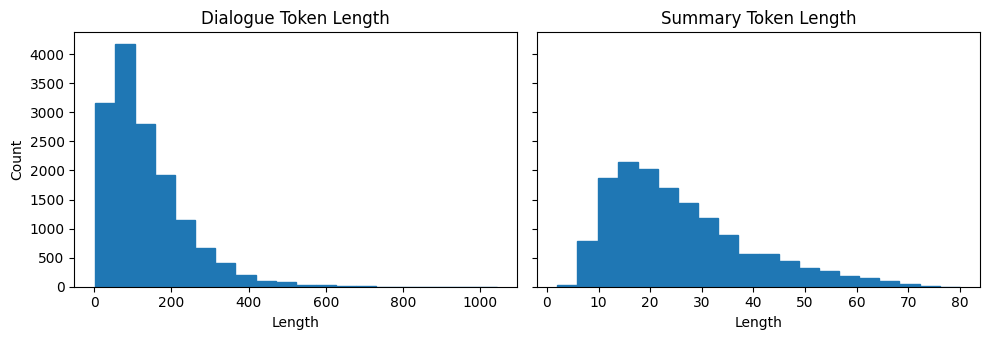

In [26]:
d_len = [len(tokenizer.encode(s)) for s in dataset_samsum["train"]["dialogue"]]
s_len = [len(tokenizer.encode(s)) for s in dataset_samsum["train"]["summary"]]

fig, axes = plt.subplots(1, 2, figsize=(10, 3.5), sharey=True)
axes[0].hist(d_len, bins=20, color="C0", edgecolor="C0")
axes[0].set_title("Dialogue Token Length")
axes[0].set_xlabel("Length")
axes[0].set_ylabel("Count")
axes[1].hist(s_len, bins=20, color="C0", edgecolor="C0")
axes[1].set_title("Summary Token Length")
axes[1].set_xlabel("Length")
plt.tight_layout()
plt.show()

In [27]:
def convert_examples_to_features(example_batch):
    input_encodings = tokenizer(example_batch["dialogue"], max_length=1024,
                                truncation=True)
    
    with tokenizer.as_target_tokenizer():
        target_encodings = tokenizer(example_batch["summary"], max_length=128,
                                     truncation=True)
    
    return {"input_ids": input_encodings["input_ids"],
            "attention_mask": input_encodings["attention_mask"],
            "labels": target_encodings["input_ids"]}

dataset_samsum_pt = dataset_samsum.map(convert_examples_to_features, 
                                       batched=True)
columns = ["input_ids", "labels", "attention_mask"]
dataset_samsum_pt.set_format(type="torch", columns=columns)

Map:   0%|          | 0/14732 [00:00<?, ? examples/s]

c:\Users\synth\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\tokenization_utils_base.py:3921: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/819 [00:00<?, ? examples/s]

Map:   0%|          | 0/818 [00:00<?, ? examples/s]

In [28]:
text = ['PAD','Transformers', 'are', 'awesome', 'for', 'text', 'summarization']
rows = []
for i in range(len(text)-1):
    rows.append({'step': i+1, 'decoder_input': text[:i+1], 'label': text[i+1]})
pd.DataFrame(rows).set_index('step')

,decoder_input,label
step,,
1,[PAD],Transformers
2,"[PAD, Transformers]",are
3,"[PAD, Transformers, are]",awesome
4,"[PAD, Transformers, are, awesome]",for
5,"[PAD, Transformers, are, awesome, for]",text
6,"[PAD, Transformers, are, awesome, for, text]",summarization


In [29]:
from transformers import DataCollatorForSeq2Seq

seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [30]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir='pegasus-samsum', num_train_epochs=1, warmup_steps=500,
    per_device_train_batch_size=1, per_device_eval_batch_size=1,
    weight_decay=0.01, logging_steps=10, push_to_hub=True,
    evaluation_strategy='steps', eval_steps=500, save_steps=1e6,
    gradient_accumulation_steps=16)

In [31]:
from huggingface_hub import login
from dotenv import load_dotenv
import os 

load_dotenv()

token = os.getenv('HUGGING_FACE_TOKEN')

login(token=token)

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: fineGrained).
Your token has been saved to C:\Users\synth\.cache\huggingface\token
Login successful


In [32]:
trainer = Trainer(model=model, args=training_args,
                  tokenizer=tokenizer, data_collator=seq2seq_data_collator,
                  train_dataset=dataset_samsum_pt["train"], 
                  eval_dataset=dataset_samsum_pt["validation"])

In [33]:
trainer.train()
score = evaluate_summaries_pegasus(
    dataset_samsum["test"], rouge_metric, trainer.model, tokenizer,
    batch_size=2, column_text="dialogue", column_summary="summary")

rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame(rouge_dict, index=[f"pegasus"])

  0%|          | 0/920 [00:00<?, ?it/s]

{'loss': 3.1995, 'grad_norm': 20.153076171875, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.01}
{'loss': 3.2262, 'grad_norm': 9.723698616027832, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.02}
{'loss': 2.9224, 'grad_norm': 11.330907821655273, 'learning_rate': 3e-06, 'epoch': 0.03}
{'loss': 2.8532, 'grad_norm': 13.839763641357422, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.04}
{'loss': 2.6905, 'grad_norm': 13.712323188781738, 'learning_rate': 5e-06, 'epoch': 0.05}
{'loss': 2.7243, 'grad_norm': 23.249996185302734, 'learning_rate': 6e-06, 'epoch': 0.07}
{'loss': 2.6229, 'grad_norm': 10.495248794555664, 'learning_rate': 7.000000000000001e-06, 'epoch': 0.08}
{'loss': 2.4229, 'grad_norm': 10.047128677368164, 'learning_rate': 8.000000000000001e-06, 'epoch': 0.09}
{'loss': 2.495, 'grad_norm': 8.687026023864746, 'learning_rate': 9e-06, 'epoch': 0.1}
{'loss': 2.437, 'grad_norm': 6.604824066162109, 'learning_rate': 1e-05, 'epoch': 0.11}
{'loss': 2.2214, 'grad_norm': 9.30210

  0%|          | 0/818 [00:00<?, ?it/s]

{'eval_loss': 1.4825278520584106, 'eval_runtime': 198.6086, 'eval_samples_per_second': 4.119, 'eval_steps_per_second': 4.119, 'epoch': 0.54}
{'loss': 1.7009, 'grad_norm': 3.8362646102905273, 'learning_rate': 4.880952380952381e-05, 'epoch': 0.55}
{'loss': 1.6748, 'grad_norm': 4.355894088745117, 'learning_rate': 4.761904761904762e-05, 'epoch': 0.56}
{'loss': 1.6809, 'grad_norm': 3.1865711212158203, 'learning_rate': 4.642857142857143e-05, 'epoch': 0.58}
{'loss': 1.5728, 'grad_norm': 3.71101975440979, 'learning_rate': 4.523809523809524e-05, 'epoch': 0.59}
{'loss': 1.6864, 'grad_norm': 5.147979259490967, 'learning_rate': 4.404761904761905e-05, 'epoch': 0.6}
{'loss': 1.7089, 'grad_norm': 4.9620184898376465, 'learning_rate': 4.2857142857142856e-05, 'epoch': 0.61}
{'loss': 1.6983, 'grad_norm': 9.830251693725586, 'learning_rate': 4.166666666666667e-05, 'epoch': 0.62}
{'loss': 1.635, 'grad_norm': 3.2401444911956787, 'learning_rate': 4.047619047619048e-05, 'epoch': 0.63}
{'loss': 1.5303, 'grad_no

100%|██████████| 410/410 [30:23:00<00:00, 266.78s/it]      


,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.018682,0.00029,0.018454,0.018511


In [34]:
pd.DataFrame(rouge_dict, index=[f"pegasus"])

,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.018682,0.00029,0.018454,0.018511


In [35]:
trainer.push_to_hub("Training complete!")

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 128, 'min_length': 32, 'num_beams': 8, 'length_penalty': 0.8, 'forced_eos_token_id': 1}


model.safetensors:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/4.98k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

events.out.tfevents.1722027032.BOSS.4496.0:   0%|          | 0.00/25.3k [00:00<?, ?B/s]

Upload 4 LFS files:   0%|          | 0/4 [00:00<?, ?it/s]

CommitInfo(commit_url='https://huggingface.co/kysnek/pegasus-samsum/commit/aa5c841e7b907ef806211198007184f4bff015b2', commit_message='Training complete!', commit_description='', oid='aa5c841e7b907ef806211198007184f4bff015b2', pr_url=None, pr_revision=None, pr_num=None)

In [36]:
import transformers
transformers.logging.set_verbosity_error()

In [37]:
gen_kwargs = {"length_penalty": 0.8, "num_beams":8, "max_length": 128}
sample_text = dataset_samsum["test"][0]["dialogue"]
reference = dataset_samsum["test"][0]["summary"]
pipe = pipeline("summarization", model="transformersbook/pegasus-samsum")

print("Dialogue:")
print(sample_text)
print("\nReference Summary:")
print(reference)
print("\nModel Summary:")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])

c:\Users\synth\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/1.35k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.61k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

Dialogue:
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye

Reference Summary:
Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry.

Model Summary:
Amanda can't find Betty's number. Larry called Betty last time they were at the park together. Hannah wants Amanda to text Larry instead of calling Betty.


In [38]:
custom_dialogue = """\
Thom: Hi guys, have you heard of transformers?
Lewis: Yes, I used them recently!
Leandro: Indeed, there is a great library by Hugging Face.
Thom: I know, I helped build it ;)
Lewis: Cool, maybe we should write a book about it. What do you think?
Leandro: Great idea, how hard can it be?!
Thom: I am in!
Lewis: Awesome, let's do it together!
"""
print(pipe(custom_dialogue, **gen_kwargs)[0]["summary_text"])

Thom, Lewis and Leandro are going to write a book about transformers. Thom helped build a library by Hugging Face. They are going to do it together.
